# Machine Learning Algorithm Trading Bot with Simple Moving Average Optimizer
Use SVC model first

#### Evaluate a New Machine Learning Classifier
Logistic Regression

#### Create an Evaluation Report



In [229]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
from finta import TA

In [230]:
# Import the dataset into a Pandas Dataframe of instrument of your choice
instrument_df = pd.read_csv(
    Path("./Resources/TSLA_5y.csv"), 
    index_col='Date', 
    infer_datetime_format=True, 
    parse_dates=True
)

# Review the DataFrame
instrument_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-12-28,44.306000,44.759998,43.439999,43.948002,43.948002,18912500
2016-12-29,43.712002,43.840000,42.824001,42.936001,42.936001,20225000
2016-12-30,43.259998,43.500000,42.335999,42.737999,42.737999,23213000
2017-01-03,42.972000,44.066002,42.192001,43.397999,43.397999,29616500
2017-01-04,42.950001,45.599998,42.862000,45.397999,45.397999,56067500


In [231]:
instrument_df= instrument_df.rename(columns=str.lower)

In [232]:
instrument_df.drop(columns=["adj close"])

,open,high,low,close,volume
Date,,,,,
2016-12-28,44.306000,44.759998,43.439999,43.948002,18912500
2016-12-29,43.712002,43.840000,42.824001,42.936001,20225000
2016-12-30,43.259998,43.500000,42.335999,42.737999,23213000
2017-01-03,42.972000,44.066002,42.192001,43.397999,29616500
2017-01-04,42.950001,45.599998,42.862000,45.397999,56067500
...,...,...,...,...,...
2021-12-20,910.700012,921.690002,893.390015,899.940002,18826700
2021-12-21,916.869995,939.500000,886.119995,938.530029,23839300
2021-12-22,965.659973,1015.659973,957.049988,1008.869995,31211400


In [233]:
df = pd.DataFrame()

In [234]:
# Create a function to find the optimal components for my trading algorithm
# Filter the date index and close columns
def trading_algo(short_window_input, long_window_input, training_period_input):
    signals_df = instrument_df.loc[:, ["close"]]

    # Use the pct_change function to generate  returns from close prices
    signals_df["Actual Returns"] = signals_df["close"].pct_change()

    # Drop all NaN values from the DataFrame
    signals_df = signals_df.dropna()


    short_window = short_window_input
    long_window =long_window_input

    # Generate the fast and slow simple moving averages (4 and 100 days, respectively)
    signals_df['SMA_Fast'] = signals_df['close'].rolling(window=short_window).mean()
    signals_df['SMA_Slow'] = signals_df['close'].rolling(window=long_window).mean()

    signals_df = signals_df.dropna()


    # Initialize the new Signal column
    signals_df['Signal'] = 0.0

    # When Actual Returns are greater than or equal to 0, generate signal to buy stock long
    signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1

    # When Actual Returns are less than 0, generate signal to sell stock short
    signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = 0


    # Calculate the strategy returns and add them to the signals_df DataFrame
    signals_df['Strategy Returns'] = signals_df['Actual Returns'] * signals_df['Signal'].shift()

    # Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
    X = signals_df[['SMA_Fast', 'SMA_Slow']].shift().dropna()

    # Create the target set selecting the Signal column and assiging it to y
    y = signals_df['Signal']

    # Select the start of the training period
    training_begin = X.index.min()

    # Select the ending period for the training data with an offset of 3 months
    training_end = X.index.min() + DateOffset(months=training_period_input)


    # Generate the X_train and y_train DataFrames
    X_train = X.loc[training_begin:training_end]
    y_train = y.loc[training_begin:training_end]


    # Generate the X_test and y_test DataFrames
    X_test = X.loc[training_end+DateOffset(hours=1):]
    y_test = y.loc[training_end+DateOffset(hours=1):]


    # Scale the features DataFrames

    # Create a StandardScaler instance
    scaler = StandardScaler()

    # Apply the scaler model to fit the X-train data
    X_scaler = scaler.fit(X_train)

    # Transform the X_train and X_test DataFrames using the X_scaler
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    X_test_scaled

    # From SVM, instantiate SVC classifier model instance
    svm_model = svm.SVC()

    # Fit the model to the data using the training data
    svm_model = svm_model.fit(X_train_scaled, y_train)

    # Use the testing data to make the model predictions
    svm_pred = svm_model.predict(X_test_scaled)


    # Use a classification report to evaluate the model using the predictions and testing data
    svm_testing_report = classification_report(y_test, svm_pred)


    # Create a new empty predictions DataFrame.

    # Create a predictions DataFrame
    predictions_df = pd.DataFrame(index=X_test.index)

    # Add the SVM model predictions to the DataFrame
    predictions_df['Predicted'] = svm_pred

    # Add the actual returns to the DataFrame
    predictions_df['Actual Returns'] = signals_df["Actual Returns"]

    # Add the strategy returns to the DataFrame
    predictions_df['Strategy Returns'] = signals_df["Actual Returns"] * predictions_df["Predicted"]


  
    # Create the column names for the dataframe to find the optimal components for the algorithm. The column names will be generated by the for loop
    df[f'{short_window}_{long_window}_{training_period}'] = (1+predictions_df["Strategy Returns"]).cumprod()
    # Plot the actual returns versus the strategy returns
    #(1+predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot(title= f"{short_window}, {long_window}, {training_period_input}")

---

## Establish a Baseline Performance using SVC Classifier model


In [235]:
# Create lists for our function to iterate through
short_window_list = [5,10,15,20,30,50]
long_window_list = [60,80,100,150,200]
training_period_list= [1,2,3,4,5,6,7,8]

In [236]:
#Create a for loop to find the optimal components for our algorithm
for short_window in short_window_list:
    for long_window in long_window_list:
        for training_period in training_period_list:
            trading_algo(short_window, long_window, training_period)

C:\Users\chaim\Anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chaim\Anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chaim\Anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chaim\Anaconda3\env

In [237]:
#tells us optimal combo for windows and training period

optimal_combo = df.columns[(df==df.iloc[-1].max()).iloc[-1]]
optimal_combo = optimal_combo[0]
print (optimal_combo)



5_100_7


In [238]:
#Need to parse out the 3 params. Isaac to work on this
split_string = optimal_combo.split("_",2)
short_win = int(split_string[0])
long_win = int(split_string[1])
train_period = int(split_string[2])
print(short_win, long_win, train_period)


5 100 7


In [239]:
df["30_150_7"]

Date
2017-05-01        NaN
2017-05-02        NaN
2017-05-03        NaN
2017-05-04        NaN
2017-05-05        NaN
               ...   
2021-12-20    0.51069
2021-12-21    0.51069
2021-12-22    0.51069
2021-12-23    0.51069
2021-12-27    0.51069
Name: 30_150_7, Length: 1174, dtype: float64

In [240]:

# Generate the fast and slow simple moving averages (4 and 100 days, respectively)
# Filter the date index and adj close columns
signals_df = instrument_df.loc[:, ["close"]]

# Use the pct_change function to generate  returns from close prices
signals_df["Actual Returns"] = signals_df["close"].pct_change()

# Drop all NaN values from the DataFrame
signals_df = signals_df.dropna()


signals_df['SMA_Fast'] = signals_df['close'].rolling(window=short_win).mean()
signals_df['SMA_Slow'] = signals_df['close'].rolling(window=long_win).mean()
bollinger_df = TA.BBANDS(instrument_df)
#macd_df = TA.MACD(instrument_df)

signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(bollinger_df)
display(macd_df)

,close,Actual Returns,SMA_Fast,SMA_Slow
Date,,,,
2017-05-23,60.771999,-0.020912,61.768400,54.57706
2017-05-24,62.043999,0.020931,61.932800,54.76814
2017-05-25,63.366001,0.021307,62.083600,54.97442
2017-05-26,65.028000,0.026229,62.656000,55.19072
2017-05-30,67.019997,0.030633,63.645999,55.40694


,BB_UPPER,BB_MIDDLE,BB_LOWER
Date,,,
2016-12-28,NaN,NaN,NaN
2016-12-29,NaN,NaN,NaN
2016-12-30,NaN,NaN,NaN
2017-01-03,NaN,NaN,NaN
2017-01-04,NaN,NaN,NaN
...,...,...,...
2021-12-20,1193.644032,1037.551498,881.458964
2021-12-21,1178.061333,1026.634500,875.207668
2021-12-22,1168.124466,1021.626498,875.128530


,MACD,SIGNAL
Date,,
2017-11-09,NaN,NaN
2017-11-10,NaN,NaN
2017-11-11,NaN,NaN
2017-11-12,NaN,NaN
2017-11-13,NaN,NaN
...,...,...
2021-12-24,-1484.572522,-2218.672262
2021-12-25,-1258.392748,-2026.616360
2021-12-26,-1036.559745,-1828.605037


## Step 2: Generate trading signals using short- and long-window SMA values based off SMA Optimizer function. 

In [241]:
signals_df = pd.concat([bollinger_df, signals_df], axis=1)

In [242]:
# Initialize the new Signal column
signals_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = 0

signals_df['Entry/Exit'] = signals_df['Signal'].diff()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())
signals_df = signals_df.dropna()

,BB_UPPER,BB_MIDDLE,BB_LOWER,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Entry/Exit
Date,,,,,,,,,
2016-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2016-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2016-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2017-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0


,BB_UPPER,BB_MIDDLE,BB_LOWER,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Entry/Exit
Date,,,,,,,,,
2021-12-20,1193.644032,1037.551498,881.458964,899.940002,-0.034989,938.785998,880.202498,0.0,-1.0
2021-12-21,1178.061333,1026.634500,875.207668,938.530029,0.042881,934.790002,882.715798,1.0,1.0
2021-12-22,1168.124466,1021.626498,875.128530,1008.869995,0.074947,941.366003,885.707798,1.0,0.0
2021-12-23,1160.579399,1019.176498,877.773598,1067.000000,0.057619,969.382007,889.280398,1.0,0.0
2021-12-27,1162.400148,1019.777493,877.154839,1093.939941,0.025248,1001.655993,893.110598,1.0,0.0


In [243]:
signals_df.count()

BB_UPPER          1158
BB_MIDDLE         1158
BB_LOWER          1158
close             1158
Actual Returns    1158
SMA_Fast          1158
SMA_Slow          1158
Signal            1158
Entry/Exit        1158
dtype: int64

In [244]:
#signals_df = signals_df[signals_df.Signal !=0]
signals_df['Signal'].value_counts()

1.0    612
0.0    546
Name: Signal, dtype: int64

In [245]:
signals_df.dropna()

,BB_UPPER,BB_MIDDLE,BB_LOWER,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Entry/Exit
Date,,,,,,,,,
2017-05-23,65.792142,62.681000,59.569858,60.771999,-0.020912,61.768400,54.577060,0.0,0.0
2017-05-24,65.792207,62.681500,59.570792,62.043999,0.020931,61.932800,54.768140,1.0,1.0
2017-05-25,65.854555,62.763500,59.672444,63.366001,0.021307,62.083600,54.974420,1.0,0.0
2017-05-26,66.127207,62.874200,59.621192,65.028000,0.026229,62.656000,55.190720,1.0,0.0
2017-05-30,66.675833,62.996900,59.317966,67.019997,0.030633,63.645999,55.406940,1.0,0.0
...,...,...,...,...,...,...,...,...,...
2021-12-20,1193.644032,1037.551498,881.458964,899.940002,-0.034989,938.785998,880.202498,0.0,-1.0
2021-12-21,1178.061333,1026.634500,875.207668,938.530029,0.042881,934.790002,882.715798,1.0,1.0
2021-12-22,1168.124466,1021.626498,875.128530,1008.869995,0.074947,941.366003,885.707798,1.0,0.0


In [246]:
# Calculate the strategy returns and add them to the signals_df DataFrame
signals_df['Strategy Returns'] = signals_df['Actual Returns'] * signals_df['Signal'].shift()

# Review the DataFrame

display(signals_df.head())
display(signals_df.tail())


,BB_UPPER,BB_MIDDLE,BB_LOWER,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Entry/Exit,Strategy Returns
Date,,,,,,,,,,
2017-05-23,65.792142,62.6810,59.569858,60.771999,-0.020912,61.768400,54.57706,0.0,0.0,NaN
2017-05-24,65.792207,62.6815,59.570792,62.043999,0.020931,61.932800,54.76814,1.0,1.0,0.000000
2017-05-25,65.854555,62.7635,59.672444,63.366001,0.021307,62.083600,54.97442,1.0,0.0,0.021307
2017-05-26,66.127207,62.8742,59.621192,65.028000,0.026229,62.656000,55.19072,1.0,0.0,0.026229
2017-05-30,66.675833,62.9969,59.317966,67.019997,0.030633,63.645999,55.40694,1.0,0.0,0.030633


,BB_UPPER,BB_MIDDLE,BB_LOWER,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Entry/Exit,Strategy Returns
Date,,,,,,,,,,
2021-12-20,1193.644032,1037.551498,881.458964,899.940002,-0.034989,938.785998,880.202498,0.0,-1.0,-0.034989
2021-12-21,1178.061333,1026.634500,875.207668,938.530029,0.042881,934.790002,882.715798,1.0,1.0,0.000000
2021-12-22,1168.124466,1021.626498,875.128530,1008.869995,0.074947,941.366003,885.707798,1.0,0.0,0.074947
2021-12-23,1160.579399,1019.176498,877.773598,1067.000000,0.057619,969.382007,889.280398,1.0,0.0,0.057619
2021-12-27,1162.400148,1019.777493,877.154839,1093.939941,0.025248,1001.655993,893.110598,1.0,0.0,0.025248


In [247]:
signals_df.dropna()

,BB_UPPER,BB_MIDDLE,BB_LOWER,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Entry/Exit,Strategy Returns
Date,,,,,,,,,,
2017-05-24,65.792207,62.681500,59.570792,62.043999,0.020931,61.932800,54.768140,1.0,1.0,0.000000
2017-05-25,65.854555,62.763500,59.672444,63.366001,0.021307,62.083600,54.974420,1.0,0.0,0.021307
2017-05-26,66.127207,62.874200,59.621192,65.028000,0.026229,62.656000,55.190720,1.0,0.0,0.026229
2017-05-30,66.675833,62.996900,59.317966,67.019997,0.030633,63.645999,55.406940,1.0,0.0,0.030633
2017-05-31,67.565961,63.218100,58.870238,68.202003,0.017637,65.132000,55.635460,1.0,0.0,0.017637
...,...,...,...,...,...,...,...,...,...,...
2021-12-20,1193.644032,1037.551498,881.458964,899.940002,-0.034989,938.785998,880.202498,0.0,-1.0,-0.034989
2021-12-21,1178.061333,1026.634500,875.207668,938.530029,0.042881,934.790002,882.715798,1.0,1.0,0.000000
2021-12-22,1168.124466,1021.626498,875.128530,1008.869995,0.074947,941.366003,885.707798,1.0,0.0,0.074947


<AxesSubplot:xlabel='Date'>

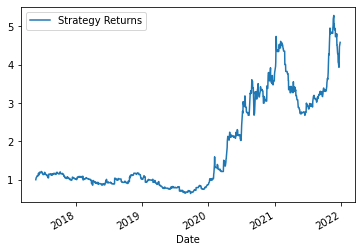

In [248]:
# Plot Strategy Returns to examine performance
(1 + signals_df[['Strategy Returns']]).cumprod().plot()

### Step 3: Split the data into training and testing datasets.

In [249]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = signals_df[['SMA_Fast', 'SMA_Slow', "BB_UPPER", "BB_MIDDLE", "BB_LOWER"]].shift().dropna()

# Review the DataFrame
X

,SMA_Fast,SMA_Slow,BB_UPPER,BB_MIDDLE,BB_LOWER
Date,,,,,
2017-05-24,61.768400,54.577060,65.792142,62.681000,59.569858
2017-05-25,61.932800,54.768140,65.792207,62.681500,59.570792
2017-05-26,62.083600,54.974420,65.854555,62.763500,59.672444
2017-05-30,62.656000,55.190720,66.127207,62.874200,59.621192
2017-05-31,63.645999,55.406940,66.675833,62.996900,59.317966
...,...,...,...,...,...
2021-12-20,952.079993,877.976597,1197.295730,1049.407501,901.519272
2021-12-21,938.785998,880.202498,1193.644032,1037.551498,881.458964
2021-12-22,934.790002,882.715798,1178.061333,1026.634500,875.207668


In [250]:
# Create the target set selecting the Signal column and assiging it to y
#signals_df = signals_df[signals_df.Signal !=0]
y = signals_df['Signal'] 

# Review the value counts
y.value_counts()

1.0    612
0.0    546
Name: Signal, dtype: int64

In [251]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2017-05-24 00:00:00


In [252]:
# Select the ending period for the training data with an offset of X months
training_end = X.index.min() + DateOffset(months=train_period)

# Display the training end date
print(training_end)

2017-12-24 00:00:00


In [253]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
y_train.count()
X_train.count()

SMA_Fast     149
SMA_Slow     149
BB_UPPER     149
BB_MIDDLE    149
BB_LOWER     149
dtype: int64

In [254]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
#X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]
#y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
display(X_test.count())
X_test

SMA_Fast     1008
SMA_Slow     1008
BB_UPPER     1008
BB_MIDDLE    1008
BB_LOWER     1008
dtype: int64

,SMA_Fast,SMA_Slow,BB_UPPER,BB_MIDDLE,BB_LOWER
Date,,,,,
2017-12-26,66.232401,67.760100,69.909067,64.519300,59.129534
2017-12-27,65.369200,67.700500,69.909696,64.524100,59.138504
2017-12-28,64.590800,67.609960,69.922910,64.465001,59.007091
2017-12-29,64.046000,67.530340,69.865862,64.543200,59.220539
2018-01-02,63.233600,67.422600,69.840477,64.568200,59.295924
...,...,...,...,...,...
2021-12-20,952.079993,877.976597,1197.295730,1049.407501,901.519272
2021-12-21,938.785998,880.202498,1193.644032,1037.551498,881.458964
2021-12-22,934.790002,882.715798,1178.061333,1026.634500,875.207668


In [255]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

#X_test_scaled[:2000]

In [256]:
len(X_train_scaled)

149

In [257]:
len(y_train)

149

### Step 4: Use the `SVC` classifier model from SKLearn's support vector machine (SVM) learning method to fit the training data and make predictions based on the testing data. Review the predictions.

In [258]:
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC()
 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test_scaled)

 #Review the model's predicted values
svm_pred[:100]
#svm_pred[:2000]

array([0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

### Step 5: Review the classification report associated with the `SVC` model predictions. 

In [259]:
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)
# Print the classification report

print(svm_testing_report)


              precision    recall  f1-score   support

         0.0       0.62      0.03      0.06       475
         1.0       0.53      0.98      0.69       533

    accuracy                           0.53      1008
   macro avg       0.57      0.51      0.38      1008
weighted avg       0.57      0.53      0.40      1008



### Step 6: Create a predictions DataFrame that contains columns for “Predicted” values, “Actual Returns”, and “Strategy Returns”.

In [260]:
# Create a new empty predictions DataFrame.

# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)
# Add the SVM model predictions to the DataFrame
predictions_df["predicted_signal"] = svm_pred
predictions_df

,predicted_signal
Date,
2017-12-26,0.0
2017-12-27,0.0
2017-12-28,1.0
2017-12-29,1.0
2018-01-02,1.0
...,...
2021-12-20,1.0
2021-12-21,1.0
2021-12-22,1.0


In [261]:

# Add the actual returns to the DataFrame
predictions_df["Actual Returns"] = signals_df["Actual Returns"]

# Add the strategy returns to the DataFrame
predictions_df["Strategy Returns"] = predictions_df["Actual Returns"] * predictions_df["predicted_signal"]
predictions_df["Entry/Exit"] = predictions_df["predicted_signal"].diff()
predictions_df["close"] = signals_df["close"]
predictions_df.tail(20)

# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())


,predicted_signal,Actual Returns,Strategy Returns,Entry/Exit,close
Date,,,,,
2017-12-26,0.0,-0.024324,-0.000000,NaN,63.458000
2017-12-27,0.0,-0.017807,-0.000000,0.0,62.327999
2017-12-28,1.0,0.011937,0.011937,1.0,63.071999
2017-12-29,1.0,-0.012716,-0.012716,0.0,62.270000
2018-01-02,1.0,0.029485,0.029485,0.0,64.106003


,predicted_signal,Actual Returns,Strategy Returns,Entry/Exit,close
Date,,,,,
2021-12-20,1.0,-0.034989,-0.034989,0.0,899.940002
2021-12-21,1.0,0.042881,0.042881,0.0,938.530029
2021-12-22,1.0,0.074947,0.074947,0.0,1008.869995
2021-12-23,1.0,0.057619,0.057619,0.0,1067.000000
2021-12-27,1.0,0.025248,0.025248,0.0,1093.939941


### Step 7: Create a cumulative return plot that shows the actual returns vs. the strategy returns. Save a PNG image of this plot. This will serve as a baseline against which to compare the effects of tuning the trading algorithm.

<AxesSubplot:xlabel='Date'>

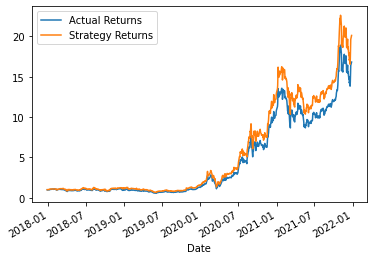

In [262]:
# Plot the actual returns versus the strategy returns
(1 + predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot()
# Baseline with 6 months training data and new SMAs


In [263]:
# Visualize entry positions relative to close price
entry = signals_df[signals_df['Entry/Exit'] == 1.0]['close'].hvplot.scatter(
    color='blue',
    marker='^',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize exit positions relative to close price
exit = signals_df[signals_df['Entry/Exit'] == -1.0]['close'].hvplot.scatter(
    color='green',
    marker='v',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize the close price for the investment
security_close = signals_df[['close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize the moving averages
moving_avgs = signals_df[['SMA_Fast', 'SMA_Slow']].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400)

# Overlay the plots
entry_exit_plot = security_close * moving_avgs * entry * exit
entry_exit_plot.opts(
    title="Trading Algorithm"
)

:Overlay
   .Curve.I          :Curve   [Date]   (close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Scatter.Close.I  :Scatter   [Date]   (close)
   .Scatter.Close.II :Scatter   [Date]   (close)

In [215]:
predictions_df.head(50)

,predicted_signal,Actual Returns,Strategy Returns,Entry/Exit,close
Date,,,,,
2017-12-26,0.0,-0.024324,-0.000000,NaN,63.458000
2017-12-27,0.0,-0.017807,-0.000000,0.0,62.327999
2017-12-28,1.0,0.011937,0.011937,1.0,63.071999
2017-12-29,1.0,-0.012716,-0.012716,0.0,62.270000
2018-01-02,1.0,0.029485,0.029485,0.0,64.106003
2018-01-03,1.0,-0.010233,-0.010233,0.0,63.450001
2018-01-04,1.0,-0.008290,-0.008290,0.0,62.924000
2018-01-05,1.0,0.006230,0.006230,0.0,63.316002
2018-01-08,1.0,0.062638,0.062638,0.0,67.281998


In [264]:
# Visualize entry positions relative to close price
entry = predictions_df[predictions_df['Entry/Exit'] == 1.0]['close'].hvplot.scatter(
    color='purple',
    marker='^',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize exit positions relative to close price
exit = predictions_df[predictions_df['Entry/Exit'] == -1.0]['close'].hvplot.scatter(
    color='orange',
    marker='v',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize the close price for the investment
security_close = predictions_df[['close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize the moving averages
moving_avgs = signals_df[['SMA_Fast', 'SMA_Slow', "BB_MIDDLE", "BB_UPPER", "BB_LOWER"]].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400)

# Overlay the plots
entry_exit_plot = security_close * moving_avgs * entry * exit
entry_exit_plot.opts(
    title="Trading Algorithm"
)

:Overlay
   .Curve.I          :Curve   [Date]   (close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Scatter.Close.I  :Scatter   [Date]   (close)
   .Scatter.Close.II :Scatter   [Date]   (close)

In [267]:
# Set the initial_capital to 100000
initial_capital = float(100000)
# Set the share_size to 500 
share_size = 500
# Create a column named "Position" by multiplying the share_size by the Signal
# Sell a position (-500 shares) when the dual moving average crossover Signal equals 1 (SMA50 is less than SMA100)
predictions_df["Position"] = share_size * predictions_df["predicted_signal"]

# Find the points in time where a 500 share position is bought or sold
predictions_df["Entry/Exit Position"] = predictions_df["Position"].diff()

# Create a Portfolio Holdings column by multiplying the Close price by the Position
predictions_df["Portfolio Holdings"] = predictions_df["close"] * predictions_df["Position"]

# To calculate Portfolio Cash, subtract the cumulative sum of the trade cost/proceeds from the initial_capital
# The trade cost proceeds are calculated by multiplying the Close price by Entry/Exit Position
predictions_df["Portfolio Cash"] = (
    initial_capital - (predictions_df["close"] * predictions_df["Entry/Exit Position"]).cumsum()
)

# Calculate the Portfolio Total value by adding Portfolio Cash and Portfolio Holdings 
predictions_df["Portfolio Total"] = predictions_df["Portfolio Cash"] + predictions_df["Portfolio Holdings"]

# Calculate the Portfolio Daily Returns based on the Portfolio Total
predictions_df["Portfolio Daily Returns"] = predictions_df["Portfolio Total"].pct_change()

# Calculate the Portfolio Cumulative Returns based on the Portfolio Daily Returns
predictions_df["Portfolio Cumulative Returns"] = (
    1 + predictions_df["Portfolio Daily Returns"]
).cumprod() - 1

# Review the DataFrame
#predictions_df.head(10)
predictions_df.tail()

,predicted_signal,Actual Returns,Strategy Returns,Entry/Exit,close,Position,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
Date,,,,,,,,,,,,
2021-12-20,1.0,-0.034989,-0.034989,0.0,899.940002,500.0,0.0,449970.0010,75434.002,525404.0030,-0.030117,4.25404
2021-12-21,1.0,0.042881,0.042881,0.0,938.530029,500.0,0.0,469265.0145,75434.002,544699.0165,0.036724,4.44699
2021-12-22,1.0,0.074947,0.074947,0.0,1008.869995,500.0,0.0,504434.9975,75434.002,579868.9995,0.064568,4.79869
2021-12-23,1.0,0.057619,0.057619,0.0,1067.000000,500.0,0.0,533500.0000,75434.002,608934.0020,0.050123,5.08934
2021-12-27,1.0,0.025248,0.025248,0.0,1093.939941,500.0,0.0,546969.9705,75434.002,622403.9725,0.022121,5.22404


In [268]:
# Visualize the entry positions relative to the Portfolio Total
entry = predictions_df[predictions_df["Entry/Exit"] == 1.0]["Portfolio Total"].hvplot.scatter(
    color='purple',
    marker='^',
    legend=False, 
    ylabel="Total Portfolio Value", 
    width=1000, 
    height=400
)

# Visualize the exit positions relative to the Portfolio Total
exit = predictions_df[predictions_df["Entry/Exit"] == -1.0]["Portfolio Total"].hvplot.scatter(
    color='orange',
    marker='v',
    legend=False, 
    ylabel="Total Portfolio Value", 
    width=1000, 
    height=400
)

# Visualize Portfolio Total for the investment
total_portfolio_value = predictions_df[["Portfolio Total"]].hvplot(
    line_color="lightgray", 
    ylabel="Total Portfolio Value", 
    width=1000, 
    height=400
)

# Overlay the entry, exit and total_portfolio_value plots
portfolio_entry_exit_plot = total_portfolio_value * entry * exit
portfolio_entry_exit_plot.opts(
    title="Algorithm - Total Portfolio Value",
    yformatter='%.0f'
)

:Overlay
   .Curve.I                    :Curve   [Date]   (Portfolio Total)
   .Scatter.Portfolio_Total.I  :Scatter   [Date]   (Portfolio Total)
   .Scatter.Portfolio_Total.II :Scatter   [Date]   (Portfolio Total)

---

## Tune the Baseline Trading Algorithm

## Step 6: Use an Alternative ML Model and Evaluate Strategy Returns

In this section, you’ll tune, or adjust, the model’s input features to find the parameters that result in the best trading outcomes. You’ll choose the best by comparing the cumulative products of the strategy returns.

### Step 1: Tune the training algorithm by adjusting the size of the training dataset. 

To do so, slice your data into different periods. Rerun the notebook with the updated parameters, and record the results in your `README.md` file. 

Answer the following question: What impact resulted from increasing or decreasing the training window?

### Step 2: Tune the trading algorithm by adjusting the SMA input features. 

Adjust one or both of the windows for the algorithm. Rerun the notebook with the updated parameters, and record the results in your `README.md` file. 

Answer the following question: What impact resulted from increasing or decreasing either or both of the SMA windows?

### Step 3: Choose the set of parameters that best improved the trading algorithm returns. 

Save a PNG image of the cumulative product of the actual returns vs. the strategy returns, and document your conclusion in your `README.md` file.

---

## Evaluate a New Machine Learning Classifier

In this section, you’ll use the original parameters that the starter code provided. But, you’ll apply them to the performance of a second machine learning model. 

### Step 1:  Import a new classifier, such as `AdaBoost`, `DecisionTreeClassifier`, or `LogisticRegression`. (For the full list of classifiers, refer to the [Supervised learning page](https://scikit-learn.org/stable/supervised_learning.html) in the scikit-learn documentation.)

In [221]:
# Import a new classifier from SKLearn
from sklearn.linear_model import LogisticRegression

# Initiate the model instance
logistic_regression_model = LogisticRegression()


### Step 2: Using the original training data as the baseline model, fit another model with the new classifier.

In [222]:
# Fit the model using the training data
lr_model = logistic_regression_model.fit(X_train_scaled, y_train)

# Use the testing dataset to generate the predictions for the new model
lr_pred = logistic_regression_model.predict(X_test_scaled)

# Review the model's predicted values
lr_pred[:10]


array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

### Step 3: Backtest the new model to evaluate its performance. 

Save a PNG image of the cumulative product of the actual returns vs. the strategy returns for this updated trading algorithm, and write your conclusions in your `README.md` file. 

Answer the following questions: 
Did this new model perform better or worse than the provided baseline model? 
This model looks to have done 
Did this new model perform better or worse than your tuned trading algorithm?

In [223]:
# Use a classification report to evaluate the model using the predictions and testing data
lr_testing_report = classification_report(y_test, lr_pred)

# Print the classification report
print(lr_testing_report)


              precision    recall  f1-score   support

         0.0       0.44      0.53      0.48       475
         1.0       0.49      0.41      0.45       533

    accuracy                           0.47      1008
   macro avg       0.47      0.47      0.47      1008
weighted avg       0.47      0.47      0.46      1008



In [224]:
# Create a new empty predictions DataFrame.

# Create a predictions DataFrame
predictions_lr_df = pd.DataFrame(index=X_test.index)
# Add the SVM model predictions to the DataFrame
predictions_lr_df["predicted_signal"] = lr_pred

# Add the actual returns to the DataFrame
predictions_lr_df["Actual Returns"] = signals_df["Actual Returns"]

# Add the strategy returns to the DataFrame
predictions_lr_df["Strategy Returns LR"] = predictions_lr_df["Actual Returns"] * predictions_lr_df["predicted_signal"]
predictions_lr_df["Entry/Exit"] = predictions_lr_df["predicted_signal"].diff()
predictions_lr_df["Adj Close"] = signals_df["close"]
predictions_lr_df.tail(20)

# Review the DataFrame
display(predictions_lr_df.head())
display(predictions_lr_df.tail())

,predicted_signal,Actual Returns,Strategy Returns LR,Entry/Exit,Adj Close
Date,,,,,
2017-12-26,0.0,-0.024324,-0.000000,NaN,63.458000
2017-12-27,1.0,-0.017807,-0.017807,1.0,62.327999
2017-12-28,1.0,0.011937,0.011937,0.0,63.071999
2017-12-29,1.0,-0.012716,-0.012716,0.0,62.270000
2018-01-02,1.0,0.029485,0.029485,0.0,64.106003


,predicted_signal,Actual Returns,Strategy Returns LR,Entry/Exit,Adj Close
Date,,,,,
2021-12-20,0.0,-0.034989,-0.0,0.0,899.940002
2021-12-21,0.0,0.042881,0.0,0.0,938.530029
2021-12-22,0.0,0.074947,0.0,0.0,1008.869995
2021-12-23,0.0,0.057619,0.0,0.0,1067.000000
2021-12-27,0.0,0.025248,0.0,0.0,1093.939941


<AxesSubplot:xlabel='Date'>

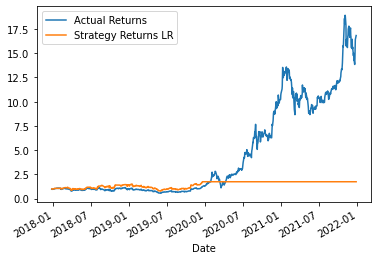

In [225]:
# Plot the actual returns versus the strategy returns
(1 + predictions_lr_df[["Actual Returns", "Strategy Returns LR"]]).cumprod().plot()
#Second Plot logistic regression 6 months training data and new SMAs

In [226]:
 #Set the initial_capital to 100000
initial_capital = float(100000)
# Set the share_size to 500 
share_size = 500
# Create a column named "Position" by multiplying the share_size by the Signal
# Sell a position (-500 shares) when the dual moving average crossover Signal equals 1 (SMA50 is less than SMA100)
predictions_lr_df["Position"] = share_size * predictions_lr_df["predicted_signal"]

# Find the points in time where a 500 share position is bought or sold
predictions_lr_df["Entry/Exit Position"] = predictions_lr_df["Position"].diff()

# Create a Portfolio Holdings column by multiplying the Close price by the Position
predictions_lr_df["Portfolio Holdings"] = predictions_lr_df["Adj Close"] * predictions_lr_df["Position"]

# To calculate Portfolio Cash, subtract the cumulative sum of the trade cost/proceeds from the initial_capital
# The trade cost proceeds are calculated by multiplying the Close price by Entry/Exit Position
predictions_lr_df["Portfolio Cash"] = (
    initial_capital - (predictions_lr_df["Adj Close"] * predictions_lr_df["Entry/Exit Position"]).cumsum()
)

# Calculate the Portfolio Total value by adding Portfolio Cash and Portfolio Holdings 
predictions_lr_df["Portfolio Total"] = predictions_lr_df["Portfolio Cash"] + predictions_lr_df["Portfolio Holdings"]

# Calculate the Portfolio Daily Returns based on the Portfolio Total
predictions_lr_df["Portfolio Daily Returns"] = predictions_lr_df["Portfolio Total"].pct_change()

# Calculate the Portfolio Cumulative Returns based on the Portfolio Daily Returns
predictions_lr_df["Portfolio Cumulative Returns"] = (
    1 + predictions_lr_df["Portfolio Daily Returns"]
).cumprod() - 1

# Review the DataFrame
predictions_lr_df.tail()

,predicted_signal,Actual Returns,Strategy Returns LR,Entry/Exit,Adj Close,Position,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
Date,,,,,,,,,,,,
2021-12-20,0.0,-0.034989,-0.0,0.0,899.940002,0.0,0.0,0.0,123382.0005,123382.0005,0.0,0.23382
2021-12-21,0.0,0.042881,0.0,0.0,938.530029,0.0,0.0,0.0,123382.0005,123382.0005,0.0,0.23382
2021-12-22,0.0,0.074947,0.0,0.0,1008.869995,0.0,0.0,0.0,123382.0005,123382.0005,0.0,0.23382
2021-12-23,0.0,0.057619,0.0,0.0,1067.000000,0.0,0.0,0.0,123382.0005,123382.0005,0.0,0.23382
2021-12-27,0.0,0.025248,0.0,0.0,1093.939941,0.0,0.0,0.0,123382.0005,123382.0005,0.0,0.23382


In [228]:
# Visualize the entry positions relative to the Portfolio Total
entry = predictions_lr_df[predictions_lr_df["Entry/Exit"] == 1.0]["Portfolio Total"].hvplot.scatter(
    color='purple',
    marker='^',
    legend=False, 
    ylabel="Total Portfolio Value", 
    width=1000, 
    height=400
)

# Visualize the exit positions relative to the Portfolio Total
exit = predictions_lr_df[predictions_lr_df["Entry/Exit"] == -1.0]["Portfolio Total"].hvplot.scatter(
    color='orange',
    marker='v',
    legend=False, 
    ylabel="Total Portfolio Value", 
    width=1000, 
    height=400
)

# Visualize Portfolio Total for the investment
total_portfolio_value = predictions_lr_df[["Portfolio Total"]].hvplot(
    line_color="lightgray", 
    ylabel="Total Portfolio Value", 
    width=1000, 
    height=400
)

# Overlay the entry, exit and total_portfolio_value plots
portfolio_entry_exit_plot = total_portfolio_value * entry * exit
portfolio_entry_exit_plot.opts(
    title="Algorithm - Total Portfolio Value",
    yformatter='%.0f'
)

:Overlay
   .Curve.I                    :Curve   [Date]   (Portfolio Total)
   .Scatter.Portfolio_Total.I  :Scatter   [Date]   (Portfolio Total)
   .Scatter.Portfolio_Total.II :Scatter   [Date]   (Portfolio Total)